# WEEK 4: Notes

In this week, we'll look at polynomial regression along with regularization applied to the california housing dataset


## Loading the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(as_frame=True, return_X_y=True)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Polynomial Regression

- To train a <span style="color: Purple">polynomial regression</span>, follow these steps:
    - **STEP 1:** Apply <span style="color: green">polynomial transformation</span> on the feature matrix
    - **STEP 2:** Learn <span style="color: green">LR model</span> (via the normal equation or SGD) on the transformed feature matrix
    
- **NOTE:** Make use of pipeline construct for poly transformation followed by LR estimator



## Normal Equation

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

poly_pipe = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2)),
    ('lin_model', LinearRegression())
])

In [31]:
poly_pipe.fit(X_train, y_train)

Pipeline(steps=[('poly_features', PolynomialFeatures()),
                ('lin_model', LinearRegression())])

In [32]:
poly_pipe.score(X_test, y_test)

0.6456819982998638

## Stochastic Gradient Descent

In [19]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

poly_pipe = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2)),
    ('lin_model', SGDRegressor())
])


poly_pipe.fit(X_train, y_train)

Pipeline(steps=[('poly_features', PolynomialFeatures()),
                ('lin_model', SGDRegressor())])

In [27]:
poly_pipe.score(X_test, y_test)

-2.7687314430448074e+43

```PolynomialFeatures(degree=2)``` would give us the following transformation:

$$
[x_1, x_2] \rightarrow [1, x_1, x_2, x_1^2, x_2^2, x_1x_2]
$$

If we want only the interactions, we can follow this ->

What are "only interaction features"? Features where we usually exclude the $x_i^p$ terms

***

```PolynomialFeatures(degree=2, interaction_only=True)``` will give us:

$$
[x_1, x_2] \rightarrow [1, x_1, x_2, x_1x_2]
$$



In [34]:
poly_pipe = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, 
                                         interaction_only=True)),
    ('lin_model', LinearRegression())
])


poly_pipe.fit(X_train, y_train)

Pipeline(steps=[('poly_features', PolynomialFeatures(interaction_only=True)),
                ('lin_model', LinearRegression())])

In [35]:
poly_pipe.fit(X_train, y_train)

poly_pipe.score(X_test, y_test)

0.622486298276293

# Hyperparameter Tuning (HPT)

- <span style="color:Blue">Hyper-Parameters</span> are parameters that are <span style="color:Blue">not directly learnt</span> within estimators

- In ```sklearn```, they are passed as <span style="color:Blue">arguments</span> to the constructor of the estimator classes

- Example:
    - ```degree``` in <span style="color:Purple">PolynomialFeatures</span>
    - ```learning rate``` in <span style="color:Purple">SGDRegressor</span>
    
***

**How to set these HPs?**

- Select HPs that result in the <span style="color:Blue">best cross validation scores</span>

- HP search consists of:
    1. An estimator
    1. A parameter space
    1. A method for searching or sampling candidates
    1. A cross-validation scheme
    1. A score function
    
- Two generic HPT approaches:
    1. ```GridSearchCV``` : exhaustive consider all parameter combinations for specific values
    
    1. ```RandomizedSearchCV```: Sampkes a given number of candidate values from a parameter space with a specified distribution

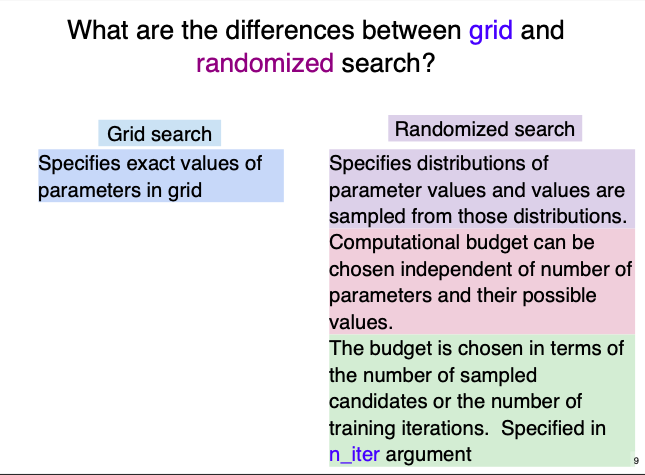

## Steps in HPT



### **STEP 1:**

Divide the data into <span style="color:Purple">training, validation</span> and <span style="color:Purple">test</span> sets

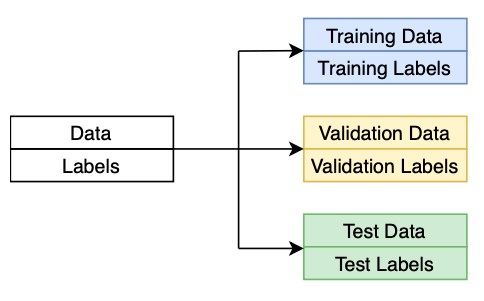


### **STEP 2:**

For each combination of HP values , learn a model with training data

 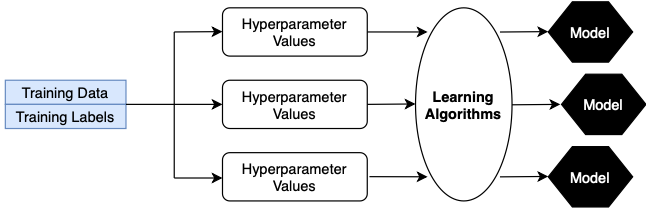

- Tips: 
    - This step can run in parallel by setting ```n_jobs = -1```
    - Some parameter combination may cause failure in fitting one or more folds of data. May cause search to fail. Set ```error_score = 0``` or ```error_score = np.nan``` to set score for the problematic fold to 0 and complete the search

### **STEP 3:**

Evaluate performance of each model with the <span style="color:Purple">validation set</span> and select a model with <span style="color:Purple">the best evaluation score</span>

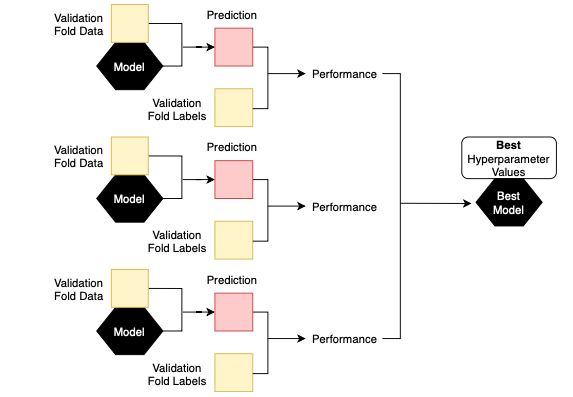



### **STEP 4:**

Retain the model with the best HP settings on training and validation set combined

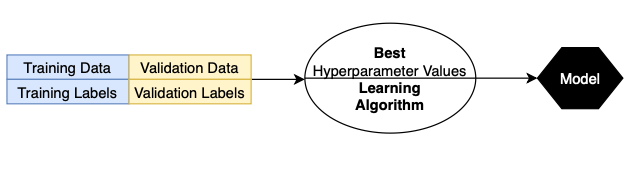



### **STEP 5:**

Evaluate performance of the model on the test set

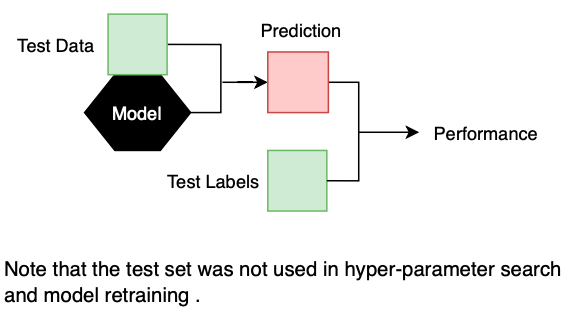


## Model Specific HPT Available for Regression Tasks

- ```linear_model.LassoCV```
- ```linear_model.RidgeCV```
- ```linear_model.ElasticNetCV```

## GridSearch - Polynomial Regression

- Let's try to determine the suitable degree of polynomial regression using grid search


***

**NOTE: To tune HP in a pipeline, your param_grid needs to have the following name syntax:** 

```nameInPipeline__parameterName```

Note that there are two underscores

***

In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'poly__degree': [1,2,3,4,5,6,7,8]} # Just one HP to tune
]

poly_pipe = Pipeline([
    ('poly', PolynomialFeatures()),
    ('SGD', SGDRegressor())
])

grid_search = GridSearchCV(poly_pipe, 
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True
                          )

grid_search.fit(X_train, y_train)

/Users/PushpakRuhil/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:961: RuntimeWarning: overflow encountered in square
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('SGD', SGDRegressor())]),
             param_grid=[{'poly__degree': [1, 2, 3, 4, 5, 6, 7, 8]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [50]:
grid_search.best_params_

{'poly__degree': 1}

In [51]:
grid_search.best_estimator_

Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                ('SGD', SGDRegressor())])

# Regularization

## Performing Ridge Regularization


- Performing Ridge Regularization With specific regularization rate( denoted with $\lambda$ in MLT)

There are 2 ways to go about it:

1. **Option 1:**
    - ***STEP 1:*** Instantiate object of ```Ridge``` estimator
    - ***STEP 2:*** Set parameter ```alpha``` to the required regularization rate
    
    Note that, alpha here is what we had as lambda in MLT
    
    ```fit, score, predict``` work exactly like other LR estimators

In [53]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha = 1e-3)


In [54]:
ridge.fit(X_train, y_train)
ridge.score(X_test, y_test)

0.5757877735520444

2. **OPTION 2:**
    - ***STEP 1:*** Istantiate object of ```SGDRegressor``` estimator
    - ***STEP 2:*** Set parameter ```alpha``` to the required regularization rate and ```penalty='l2'```

In [55]:
sgd = SGDRegressor(alpha=1e-3, penalty='l2')

sgd.fit(X_train, y_train)
sgd.score(X_test, y_test)

-4.528453021830375e+28

## Ridge Regularization in Polynomial Regression


In [57]:
# Setup a pipeline with poly transformation
# Followed by Ridge Regressor

poly_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('ridge', Ridge(alpha=1e-3))
])

poly_pipe.fit(X_train, y_train)

/Users/PushpakRuhil/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.98797e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Pipeline(steps=[('poly', PolynomialFeatures()), ('ridge', Ridge(alpha=0.001))])

In [58]:
poly_pipe.score(X_test, y_test)

0.6477197739878146

## LASSO Regularization

1. **Option 1:**
    - ***STEP 1:*** Instantiate object of ```Lasso``` estimator
    - ***STEP 2:*** Set parameter ```alpha``` to the required regularization rate

In [59]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=1e-3)

lasso.fit(X_train, y_train)
lasso.score(X_test, y_test)

0.5773121026225017

1. **Option 2:**
    - ***STEP 1:*** Instantiate object of ```SGDRegressor``` estimator
    - ***STEP 2:*** Set parameter alpha to the required regularization rate and ```penalty='l1'```

In [60]:
sgd = SGDRegressor(alpha=1e-3, penalty='l1')

sgd.fit(X_train, y_train)
sgd.score(X_test, y_test)

-2.4833531793170667e+29

### Searching for the best Reg. Parameter for LASSO

1. **Option 1:**
    - Search for the best reg. rate with built-in CV in ```lassoCV``` estimator

1. **Option 2:**
    - Use cross validation with ```Lasso``` or ```SVDRegressor``` to search for the best regularization.
        - Grid Search
        - Randomized Search

## LASSO Regularization in Polynomial Regression

In [61]:
# Setup a pipeline with poly transformation
# Followed by LASSO Regressor

poly_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('lasso', Lasso(alpha=1e-3))
])

poly_pipe.fit(X_train, y_train)

/Users/PushpakRuhil/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.828e+03, tolerance: 2.207e+00
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('poly', PolynomialFeatures()), ('lasso', Lasso(alpha=0.001))])

In [62]:
poly_pipe.score(X_test, y_test)

0.633125426026389

## Combination of Ridge and LASSO - ElasticNet


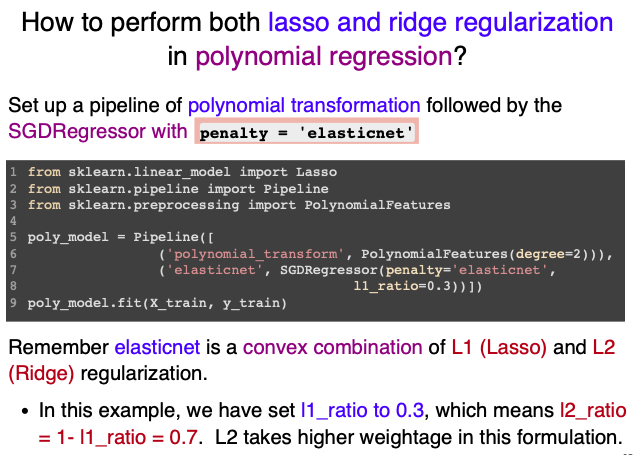